### Visualización y preprocesamiento de los datos

En este notebook utilizaremos el conjunto que hemos inspeccionado y adecuado para crear unas sencillas representaciones de los datos  y posteriormente aplicar tecnica de preprocesamiento realizar un sencillo modelo que nos ayude a analizar los sentimientos descritos en las diferentes reseñas. Así, el siguiente script está dividido en los siguientes bloques:

- **BLOQUE A**: carga de datos inspeccionados.
- **BLOQUE B**: visualización. 
- **BLOQUE C**: preprocesamiento de los textos.
- **BLOQUE D**: partición del conjunto de datos en train y test.
- **BLOQUE E**: balanceo de los datos.
- **BLOQUE F**: vectorización de los conjuntos de datos.

In [3]:
import pandas as pd
import re
import pickle
import joblib
import random

import seaborn as sns
import matplotlib.pyplot as plt 

from wordcloud import WordCloud
import nltk

nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cristian.robledo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/cristian.robledo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### BLOQUE A: Carga de datos
Antes de comenzar, cargaremos los datos que han sido adecuados en nuestra fase anterior de limpieza:

In [4]:
# Carga de datos ya adecuados
df = pd.read_csv('../data/spam_filtered.csv')

In [5]:
# ¿Que dimensiones tiene el conjunto de datos?
df.shape

(4028, 3)

In [6]:
# Mostramos las primeras observaciones del conjunto
df.head()

,target,text,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
2,ham,U dun say so early hor... U c already then say...,49
3,ham,"Nah I don't think he goes to usf, he lives aro...",61
4,spam,FreeMsg Hey there darling it's been 3 week's n...,148


### BLOQUE B: visualización

En este bloque utilizaremos las librerias [matplotlib](https://matplotlib.org/) y [seaborn](https://seaborn.pydata.org/) para crear unas sencillas representaciones de los datos a modo general y descriptivo, mientras que  nos ayudaremos de la librería [wordcloud](https://amueller.github.io/word_cloud/) para poder crear visualizaciones acerca de los textos que vamos a analizar.

/tmp/ipykernel_87850/1052266913.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', palette='viridis', data=df)


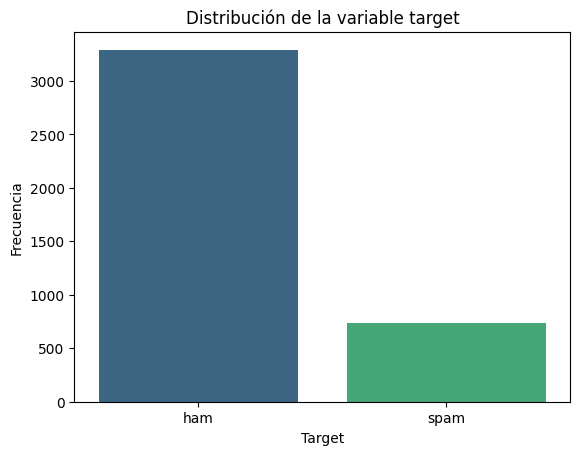

In [7]:
# Gráfico de barras para la variable target
sns.countplot(x='target', palette='viridis', data=df)
plt.title('Distribución de la variable target')
plt.ylabel('Frecuencia')
plt.xlabel('Target')
plt.show()

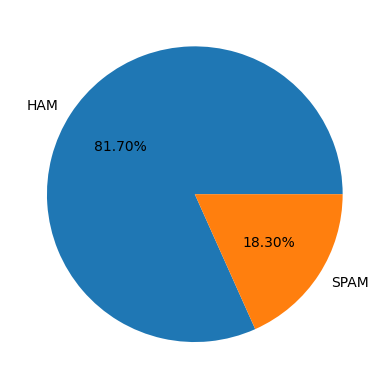

In [8]:
# Gráfico 'pie' con porcentajes para la variable objetivo 
plt.pie(df['target'].value_counts(), autopct="%.2f%%", labels=['HAM', 'SPAM'])
plt.show()

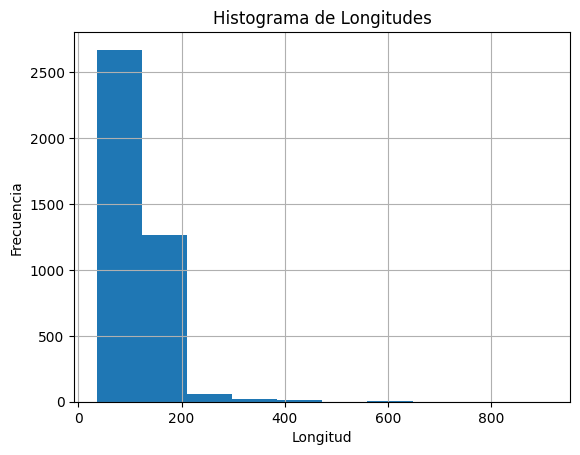

In [9]:
# Histograma de la distribución de las logitudes de los SMS.
# Utilizamos los histogramas proporcionados por el propio dataframe.
df['length'].hist()
plt.title('Histograma de Longitudes')
plt.xlabel('Longitud')
plt.ylabel('Frecuencia')
plt.show()

/tmp/ipykernel_87850/788625809.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y='length', data=df, palette='Set2')


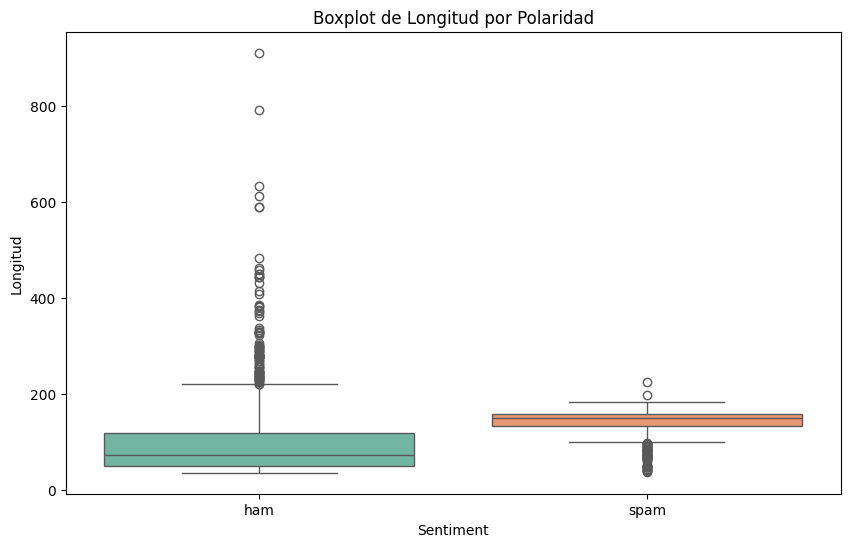

In [10]:
# Distribución de la longitud por cada tipo de clase
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='length', data=df, palette='Set2')
plt.title('Boxplot de Longitud por Polaridad')
plt.xlabel('Sentiment')
plt.ylabel('Longitud')
plt.show()

Vamos a crear un gráfico de las palabras más comunes en los SMS para cada clase:

In [11]:
# Filtramos los textos por sus etiquetas

# textos no spam
ham_texts = df.loc[df['target']=='ham', 'text']

# textos spam
spam_texts = df.loc[df['target']=='spam', 'text']

In [12]:
# Función para poder realizar el gráfico
def wordcloud_draw(data, color, title):
    words = ' '.join(data)
    wordcloud = WordCloud(stopwords=stopwords.words('english'),
                          background_color=color,
                          width=2500,height=2000).generate(words)
    plt.imshow(wordcloud)
    plt.title(title)
    plt.axis('off')

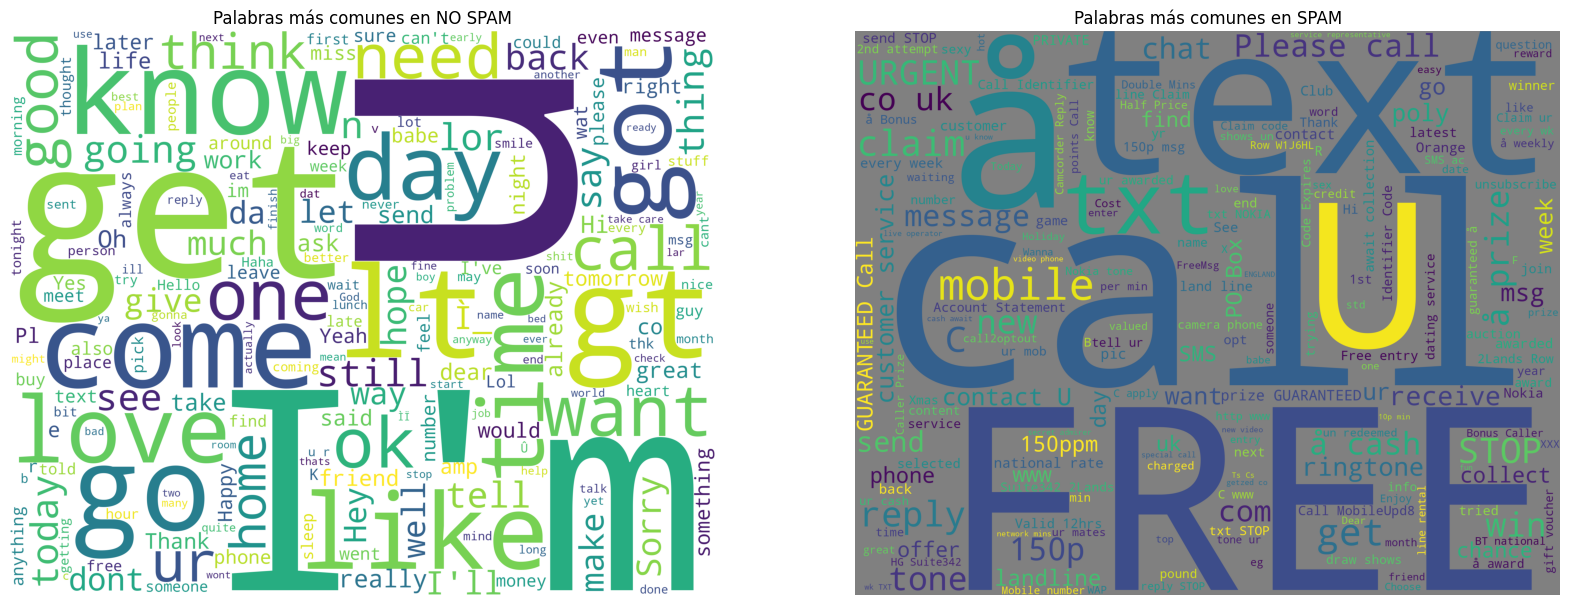

In [13]:
# Representamos los dos gráficos en una sola visualización
plt.figure(figsize=[20,10])
plt.subplot(1,2,1)
wordcloud_draw(ham_texts,'white','Palabras más comunes en NO SPAM')

plt.subplot(1,2,2)
wordcloud_draw(spam_texts, 'grey','Palabras más comunes en SPAM')
plt.show()

### BLOQUE C: Preprocesamiento del texto

El preprocesamiento del texto es una fase importante dentro del Procesamiento del Lenguaje Natural (NLP). El objetivo de esta fase es la de transformar el texto en crudo, de manera que sea más fácilmente consumible por los algoritmos y modelos de Machine Learning (ML) y Deep Learning (DL) a aplicar.

Esta fase consta de diferentes pasos y no son siempre los mismos. En este caso, preprocesaremos los SMS de la siguiente manera:

1. **Lower Casing**: Transformar mayúsculas a minúsculas.

2. **Eliminar Non-Alphabets**: Reemplazar todos los caracteres que no aparecen en el abecedario por un espacio.

3. **Eliminar letras consecutivas**: 3 o más letras consecutivas son reemplazadas por 2 letras (ejemplo: "Heyyyy" por "Heyy").

4. **Tokenizacíon**:  proceso de dividir un texto en unidades más pequeñas llamadas tokens (en este caso, palabras).

5. **Eliminar Stopwords**: Las Stopwords son aquellas palabras que no tienen un significado específico por si solas, por lo que pueden ser ignoradas sin sacrificar el significado de la oración (ejemplos en inglés: "the", "a").

6. **Eliminar palabras cortas**: Palabras con menos de 2 letras son eliminadas.

In [14]:
# Función para preprocesar el texto en crudo
def preprocess(text):    

    # Definir patrones para reemplazar/eliminar.
    alphaPattern      = "[^a-zA-Z]"
    sequencePattern   = r"(.)\1\1\1*"
    seqReplacePattern = r"\1\1"    
    
    # Crear lista de stopwords
    en_stop =  set(stopwords.words('english')) - {'not','no'}  # o definirlo manualmente set(['a', 'an', 'the', 'in', 'does', 'do'])

    # Lower Casing
    text = text.lower()

    # Reemplazar non-alphabets.
    text = re.sub(alphaPattern, " ", text)

    # Reemplazar letras consecutivas.
    text = re.sub(sequencePattern, seqReplacePattern, text)
    
    # Tokenizar texto
    tokens = word_tokenize(text)

    # Eliminar stopwords
    tokens = [word for word in tokens if word not in en_stop]
    
    # Eliminar tokens con menos de dos elementos/caracteres
    tokens = [word for word in tokens if len(word)>2]
    
    return tokens

In [15]:
# Aplicamos la función a cada una de los SMS
df['preprocess_text'] = df['text'].apply(preprocess)

In [16]:
# Resultados del preprocesamiento: un ejemplo
print('SMS en crudo:', df.loc[0, 'text'])
print('SMS preprocesado:', df.loc[0, 'preprocess_text'])

SMS en crudo: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
SMS preprocesado: ['jurong', 'point', 'crazy', 'available', 'bugis', 'great', 'world', 'buffet', 'cine', 'got', 'amore', 'wat']


### BLOQUE D: Partición del conjunto de datos en train y test (80,20)

In [17]:
X = df['preprocess_text']
y = df['target']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [18]:
# Información acerca de los conjuntos
print('Tamaño del conjunto de entrenamiento:', len(X_train))
print('Tamaño del conjunto de test:', len(X_test))

Tamaño del conjunto de entrenamiento: 3222
Tamaño del conjunto de test: 806


### BLOQUE D: Balanceo de los datos

Si hablamos de problemas de modelado centrados en la clasificación, podemos encontrarnos con **conjuntos de datos** en las que la variable objetivo contiene clases muy **desequilibradas**, es decir, categorías con frecuencias muy diferentes.

Al entrenar un modelo de clasificación con la variable no balanceada, encontraremos algunos problemas. Esto sucede porque el patrón de datos de la clase dominante superará a los de la clase con menos frecuencia. Como una de las clases tiene una frecuencia muy alta, el modelo construido con datos desequilibrados puede presentar una precisión muy alta y aun así no predecir correctamente ninguna observación para la clase con una frecuencia más baja. Esto puede dar la falsa impresión de que el modelo funciona bien cuando en realidad no es así.

Para solucionar estos problemas podemos recurrir a una solución: **equilibrar o balancear los datos de la variable objetivo**.

Como los modelos deben funcionar en el mundo real, este balanceo solo es necesario realizarlo en el **conjunto de entrenamiento**. De esta manera, el conjunto de test sobre el que evaluaremos el rendimiento de nuestros modelos seguirá reflejando lo más fielmente posible la realidad a la que se aplicarán.

In [24]:
# Separar conjunto de datos de entrenamiento según clases
X_train_spam = X_train[y_train == 'spam']
y_train_spam = y_train[y_train == 'spam']

X_train_no_spam = X_train[y_train == 'ham']
y_train_no_spam = y_train[y_train == 'ham']

# Submuestrear (undesampling) la clase mayoritaria
X_train_no_spam_resampled, y_train_no_spam_resampled = resample(X_train_no_spam, 
                                                                y_train_no_spam,
                                                                replace=False,  # sin reemplazo
                                                                n_samples=len(y_train_spam),  # igualar tamaño al de "spam"
                                                                random_state=42)

# Combinar clases balanceadas
X_train_balanced = pd.concat([X_train_spam, X_train_no_spam_resampled])
y_train_balanced = pd.concat([y_train_spam, y_train_no_spam_resampled])

In [25]:
# Información acerca de los conjuntos tras balanceo
print('Tamaño del conjunto de entrenamiento:', len(X_train_balanced))
print('Tamaño del conjunto de test:', len(X_test))

Tamaño del conjunto de entrenamiento: 1180
Tamaño del conjunto de test: 806


In [26]:
# Frequencias relativas de la variable 'target' en el conjunto de entrenamiento
round(y_train_balanced.value_counts(normalize=True), 2)

target
spam    0.5
ham     0.5
Name: proportion, dtype: float64

In [27]:
# Frequencias relativas de 'target' en el conjunto de test
round(y_test.value_counts(normalize=True), 2)

target
ham     0.82
spam    0.18
Name: proportion, dtype: float64

### BLOQUE E: Vectorización del texto

Antes de dar el texto en input a un modelo es necesario vectorizarlo: convertir las palabras en números.

La conversión del texto en una representación númerica es uno de los pasos más importantes dentro de cualquier *pipeline* de NLP. Esta conversión resulta esencial para que las "máquinas" puedan comprender y decodificar patrones dentro de cualquier lenguaje.

Se trata de un proceso iterativo y que puede ser realizado mediante múltiples maneras o técnicas, abarcando desde las representaciones más sencillas (por ejemlo, One hot encoding) hasta otras más "inteligentes", que logran tener en cuenta las similitudes y diferencias entre ellas al basar su aprendizaje en redes neuronales (Word embeddings).

En este caso vamos a utilizar la técnica **TF-IDF (Term Frequency-Inverse Document Frequency)**. A continuación, se describen los conceptos clave:

1. **Term Frequency (TF)**:
Mide la frecuencia de un término específico en un texto.
Se calcula dividiendo el número de veces que un término aparece en un texto entre el número total de términos en el propio texto.
Cuanto más frecuente es un término, mayor es su valor de TF.

2. **Inverse Document Frequency (IDF)**:
Mide la importancia de un término en el conjunto de textos.
Se calcula tomando el logaritmo del inverso de la proporción de textos que contienen el término.
Así, los términos que aparecen en muchos textos tendrán un IDF más bajo, ya que se consideran menos informativos.

3. **TF-IDF**:
Combina TF y IDF para asignar un peso a cada término en cada texto: **TF-IDF = TF * IDF** .\
Los términos que son frecuentes en un texto pero raros en el conjunto de textos tendrán un alto valor de TF-IDF, lo que indica su importancia relativa en ese texto específico.

In [28]:
# Vectorización de textos
# Cargamos el vectorizador
vectorizer = TfidfVectorizer() 

# fit_transform() determina qué palabras existen en el conjunto de datos y asigna un índice a cada una de ellas
X_train_vec = vectorizer.fit_transform([" ".join(tokens) for tokens in X_train_balanced])

In [29]:
# Transformamos nuevos datos (conjunto de test) en función del vocabulario aprendido anteriormente (con el conjunto de entrenamiento)
X_test_vec = vectorizer.transform([" ".join(tokens) for tokens in X_test])

Vamos a ver con más detalle el objecto generado con `TfidfVectorizer`:

In [30]:
type(X_train_vec)

scipy.sparse._csr.csr_matrix

 Se trata de una matriz dispersa (*sparse matrix*) en formato CSR (*Compressed Sparse Row*). Una matriz dispersa es una estructura de datos que se utiliza para almacenar matrices que tienen una gran cantidad de elementos cero.

In [ ]:
# Obtener dimensiones
num_textos, num_terminos = X_train_vec.shape

print(f"Número de Textos: {num_textos}")
print(f"Número de Términos: {num_terminos}")


Número de Textos: 1180
Número de Términos: 3245


In [32]:
# Escogemos 10 palabras al azar  
random.sample(list(vectorizer.get_feature_names_out()), 10)

['location',
 'shop',
 'important',
 'goldviking',
 'dobby',
 'charity',
 'seen',
 'mrng',
 'goodnight',
 'bleh']

Comprobamos el valor TF-IDF asignado a algunas palabras en el primer texto:

In [35]:
# Almacenamos los términos obtenidos mediante el objeto vectorizer para utilizarlos de manera más directa
terminos = vectorizer.get_feature_names_out()

# Primer documento como vector TF-IDF
vector_tfidf_primer_documento = X_train_vec[0]

# Crear un DataFrame para visualizar el resultado
df_terminos = pd.DataFrame(vector_tfidf_primer_documento.toarray(), columns=terminos)

In [39]:
# Valor TF-IDF asignado a una palabra contenida en el texto
df_terminos['break']

0    0.325574
Name: break, dtype: float64

In [42]:
# Valor TF-IDF asignado a una palabra no presente en el texto
df_terminos['bad']

0    0.0
Name: bad, dtype: float64

### BLOQUE E: Exportación de los conjuntos preprocesados

En esta última fase exportamos y guardamos los conjuntos preprocesados en la carpeta 'data', para poderlos utilizar en las próximas tareas de modelado. 


In [43]:
# ¿De que tipo son los conjuntos resultantes?
print(f'X_train: {type(X_train_balanced)}')
print(f'X_train_vec: {type(X_train_vec)}')
print(f'y_train: {type(y_train_balanced)}')

X_train: <class 'pandas.core.series.Series'>
X_train_vec: <class 'scipy.sparse._csr.csr_matrix'>
y_train: <class 'pandas.core.series.Series'>


Vamos a guardarlos como archivos binarios utilizando **pickle**, que es una forma general de serializar objetos en Python

In [44]:
# Guardamos los conjuntos X
with open('../data/x_train.pkl', 'wb') as file:
    pickle.dump(X_train_balanced, file)

with open('../data/x_test.pkl', 'wb') as file:
    pickle.dump(X_test, file)

In [45]:
# Guardamos los conjuntos de textos vectorizados
with open('../data/x_train_vec.pkl', 'wb') as file:
    pickle.dump(X_train_vec, file)

with open('../data/x_test_vec.pkl', 'wb') as file:
    pickle.dump(X_test_vec, file)

In [46]:
# Guardamos las variables objetivo
with open('../data/y_train.pkl', 'wb') as file:
    pickle.dump(y_train_balanced, file)

with open('../data/y_test.pkl', 'wb') as file:
    pickle.dump(y_test, file)

In [47]:
# Guardamos el objeto vectorizer en un fichero 
joblib.dump(vectorizer, '../models/tfidf_vectorizer.joblib')

['../models/tfidf_vectorizer.joblib']